# Object detection and tracking

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

from sympy.codegen import Print

%matplotlib inline

## Color Detection - Finding Red Objects in Camera Feed

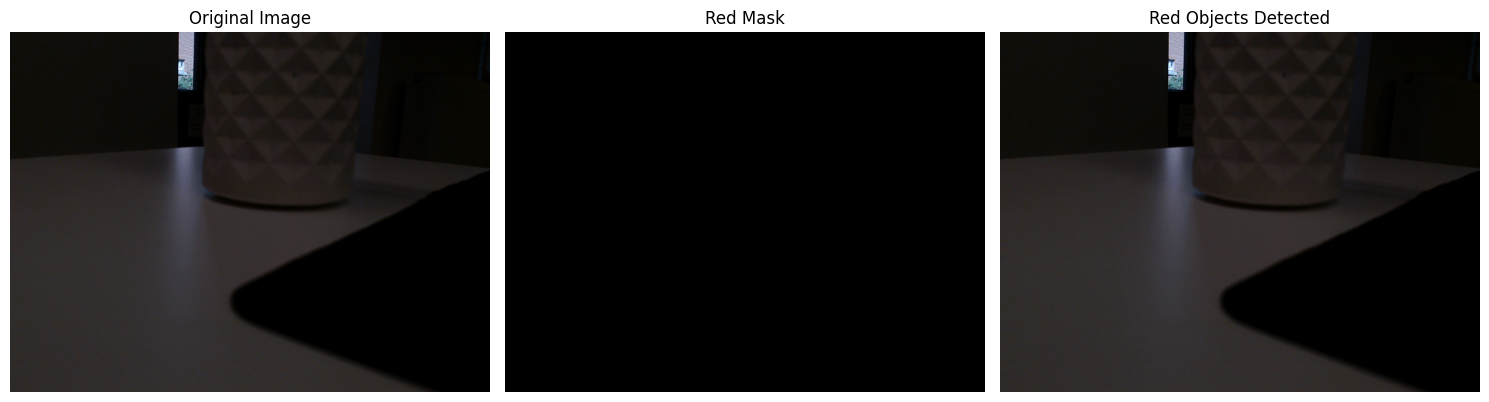

In [2]:
# Initialize camera
cap = cv2.VideoCapture(0)  # Use 0 for default webcam

# Capture a single frame
ret, frame = cap.read()
if ret:
    # Convert to RGB for display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Convert to HSV for color detection
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define range for red color (note: red wraps around in HSV, so we need two masks)
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    # Create masks for red regions
    mask1 = cv2.inRange(frame_hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(frame_hsv, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw rectangles around red objects
    result = frame_rgb.copy()
    for contour in contours:
        # Filter small contours
        if cv2.contourArea(contour) > 500:  # Minimum area threshold
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(result, "Red Object", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display results
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.imshow(frame_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(mask, cmap='gray')
    plt.title('Red Mask')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(result)
    plt.title('Red Objects Detected')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Release the camera
    cap.release()
else:
    print("Failed to capture image from camera")

In [6]:
import numpy as np

import numpy as np
import cv2

# Convert hex RGB to BGR tuple for OpenCV
bgr_target = (0x76, 0x9D, 0x5E)  # (118, 157, 94)

# Create a 1×1 image to convert BGR to HSV
pixel = np.uint8([[bgr_target]])
hsv_target = cv2.cvtColor(pixel, cv2.COLOR_BGR2HSV)[0][0]

# Set tolerances
tol_h, tol_s, tol_v = 10, 50, 50

# Compute lower/upper HSV bounds
lower_custom = np.array([
    max(int(hsv_target[0]) - tol_h, 0),
    max(int(hsv_target[1]) - tol_s, 0),
    max(int(hsv_target[2]) - tol_v, 0)
])
upper_custom = np.array([
    min(int(hsv_target[0]) + tol_h, 179),
    min(int(hsv_target[1]) + tol_s, 255),
    min(int(hsv_target[2]) + tol_v, 255)
])
print("Lower HSV:", lower_custom)
print("Upper HSV:", upper_custom)

Lower HSV: [ 61  52 107]
Upper HSV: [ 81 152 207]


In [8]:
## Real-time Red Color Detection

In [7]:
 # For continuous detection (press 'q' to quit)

# Kalman filter setup
kf = cv2.KalmanFilter(4, 2, 0)
kf.transitionMatrix = np.array([[1,0,1,0],
                                [0,1,0,1],
                                [0,0,1,0],
                                [0,0,0,1]], np.float32)
kf.measurementMatrix = np.eye(2,4, dtype=np.float32)
kf.processNoiseCov = np.eye(4, dtype=np.float32) * 1e-2
kf.measurementNoiseCov = np.eye(2, dtype=np.float32) * 1e-1

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
cap.set(cv2.CAP_PROP_FPS, 60)
initialized = False

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to HSV
        frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Define range for green colour
        lower_green = np.array([61, 32, 107])
        upper_green = np.array([81, 152, 255])

        # Define range for purple colour
        lower_purple = np.array([126, 141, 87])
        upper_purple = np.array([146, 241, 187])

        # Define range for red colour (note: red wraps around in HSV, so we need two masks)
        lower_red1 = np.array([0, 100, 100])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([160, 100, 100])
        upper_red2 = np.array([180, 200, 200])

        # Create mask
        mask_green = cv2.inRange(frame_hsv, lower_green, upper_green)
        mask_red = cv2.inRange(frame_hsv, lower_red1, upper_red1) | cv2.inRange(frame_hsv, lower_red2, upper_red2)
        mask_purple = cv2.inRange(frame_hsv, lower_purple, upper_purple)

        # Morphological closing to unite nearby purple regions
        kernel = np.ones((5, 5), np.uint8)
        mask_purple_closed = cv2.morphologyEx(mask_purple, cv2.MORPH_CLOSE, kernel, iterations=2)

        # Find contours on the closed mask
        contours_purple, _ = cv2.findContours(mask_purple_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


        # Find contours
        contours_red, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_green, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #contours_purple, _ = cv2.findContours(mask_purple, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Predict step always runs
        prediction = kf.predict()
        pred_x, pred_y = int(prediction[0]), int(prediction[1])


        # Draw rectangles around green objects
        for contour in contours_red:
            # TODO: Estimate the size of the object (in our case, a beanie from a distance of x meters, what is the reliable distance?)
            # Size of the beanie is approximately 20 cm in diameter -> Size of the contour should be around 20 cm in pixels
            # Diameter of the circle is approximately 300 cm
            # 1024 pixels = 300 cm
            #
            if cv2.contourArea(contour) > 100 and cv2.contourArea(contour) < 190:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)  # Red rectangle for visibility
                cv2.putText(frame, "Red Object", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        for contour in contours_green:
            if cv2.contourArea(contour) > 100:# and cv2.contourArea(contour) < 190:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)  # Red rectangle for visibility
                cv2.putText(frame, "Green Object", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)



        if contours_purple:
            # Combine all contour points
            all_pts = np.vstack(contours_purple)

            # Option A: single bounding rectangle
            #x, y, w, h = cv2.boundingRect(all_pts)
            #pointx, pointy = x + y / 2, w + h / 2
            #print("Pointx: ", pointx, "Pointy: ", pointy)

            M = cv2.moments(all_pts)

            if M["m00"] != 0:
                cx = float(M["m10"] / M["m00"])
                cy = float(M["m01"] / M["m00"])

                # --- 3. Initialize filter on first valid centroid ---
                if not initialized:
                    kf.statePost = np.array([[cx],
                                              [cy],
                                              [0],
                                              [0]], np.float32)
                    initialized = True

                # --- 4. Correct step with new measurement ---
                measurement = np.array([[cx], [cy]], np.float32)
                est = kf.correct(measurement)
                est_x, est_y = int(est[0]), int(est[1])

                # draw filtered center
                cv2.circle(frame, (est_x, est_y), 5, (255, 0, 255), -1)
                cv2.putText(frame,
                            f"KF Center: ({est_x},{est_y})",
                            (est_x + 10, est_y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1)
            else:
                # draw predicted center if no detection
                cv2.circle(frame, (pred_x, pred_y), 5, (0, 255, 255), -1)
                cv2.putText(frame,
                            "KF Predict",
                            (pred_x + 10, pred_y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

        # Display result
        cv2.imshow('Green Color Detection', frame)

        # Break loop on 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)  # This helps ensure all windows are closed properly

C:\Users\Jolan\AppData\Local\Temp\ipykernel_6784\370984796.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_x, pred_y = int(prediction[0]), int(prediction[1])
